In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore


In [13]:
# Configuración de estilo
sns.set_style("whitegrid")

# Ruta del archivo CSV
archivo_csv = "/Users/ximenacanton/Documents/TEC/4 SEM/ACD/pisa/CONTIFORM_MMA_CONTIFORM_MMA1_WS_Tot_Rej_0.csv"  # MODIFICA ESTO

# Cargar el CSV
data = pd.read_csv(archivo_csv)


In [14]:
# ---- 1.1. Análisis Descriptivo Inicial ----
print("Información del dataset:")
print(data.info())
print("\nValores nulos:")
print(data.isnull().sum())
print("\nValores duplicados:")
print(data.duplicated().sum())

# Resumen estadístico
print("\nResumen estadístico:")
print(data.describe(percentiles=[0.25, 0.5, 0.75]))


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57097 entries, 0 to 57096
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_ts   57097 non-null  object 
 1   variable  57097 non-null  object 
 2   value     57094 non-null  float64
 3   message   0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 1.7+ MB
None

Valores nulos:
user_ts         0
variable        0
value           3
message     57097
dtype: int64

Valores duplicados:
727

Resumen estadístico:
              value  message
count  57094.000000      0.0
mean    3231.291712      NaN
std     2959.888226      NaN
min        0.000000      NaN
25%     1050.250000      NaN
50%     2435.000000      NaN
75%     4530.000000      NaN
max    18170.000000      NaN


<Figure size 1000x500 with 0 Axes>

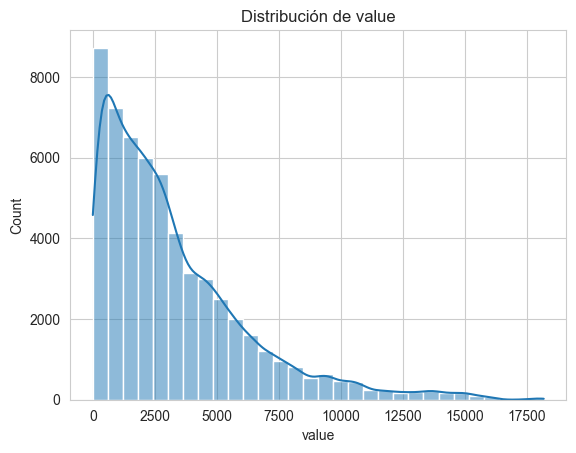

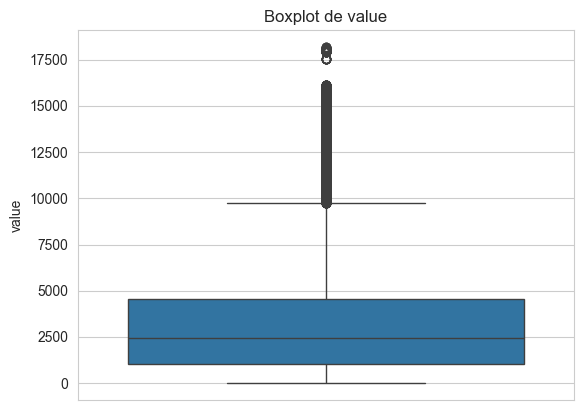


Valores atípicos detectados en 'value' (Z-score > 3):
48287    12118.0
48288    12127.0
48289    12137.0
48290    12147.0
48291    12157.0
          ...   
52128    15174.0
52129    15175.0
52130    15178.0
52131    15184.0
52132    15187.0
Name: value, Length: 1148, dtype: float64
La columna 'message' tiene valores insuficientes para graficar.

Valores atípicos detectados en 'message' (Z-score > 3):
No se encontraron valores atípicos con Z-score.

Valores atípicos detectados en 'value' por IQR:
22061     9752.0
22062     9762.0
22063     9772.0
22064     9781.0
22065     9791.0
          ...   
52128    15174.0
52129    15175.0
52130    15178.0
52131    15184.0
52132    15187.0
Name: value, Length: 2487, dtype: float64

Valores atípicos detectados en 'message' por IQR:
No se encontraron valores atípicos con IQR.


In [15]:


# ---- 1.2. Análisis de Distribución y Detección de Outliers ----
plt.figure(figsize=(10, 5))

for col in data.select_dtypes(include=np.number).columns:
    col_data = data[col].dropna()  # Eliminar valores NaN
    
    if col_data.nunique() > 1:  # Verificar que haya más de un valor único
        # Histograma y KDE
        plt.figure()
        sns.histplot(col_data, kde=True, bins=30)
        plt.title(f"Distribución de {col}")
        plt.show()

        # Boxplot
        plt.figure()
        sns.boxplot(y=col_data)
        plt.title(f"Boxplot de {col}")
        plt.show()
    else:
        print(f"La columna '{col}' tiene valores insuficientes para graficar.")

    # Z-score para detectar outliers
    z_scores = np.abs(zscore(col_data))
    outliers_z = col_data[z_scores > 3]
    
    print(f"\nValores atípicos detectados en '{col}' (Z-score > 3):")
    if not outliers_z.empty:
        print(outliers_z)
    else:
        print("No se encontraron valores atípicos con Z-score.")

# IQR (Método de rango intercuartílico) para detectar outliers
for col in data.select_dtypes(include=np.number).columns:
    col_data = data[col].dropna()  # Eliminar valores NaN

    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    outliers_iqr = col_data[(col_data < (Q1 - 1.5 * IQR)) | (col_data > (Q3 + 1.5 * IQR))]

    print(f"\nValores atípicos detectados en '{col}' por IQR:")
    if not outliers_iqr.empty:
        print(outliers_iqr)
    else:
        print("No se encontraron valores atípicos con IQR.")



✅ La columna 'fecha' existe. Convirtiendo a formato datetime...

<class 'pandas.core.frame.DataFrame'>
Index: 57054 entries, 0 to 57096
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   user_ts   57054 non-null  datetime64[ns, UTC]
 1   variable  57054 non-null  object             
 2   value     57051 non-null  float64            
 3   message   0 non-null      float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 2.2+ MB
None


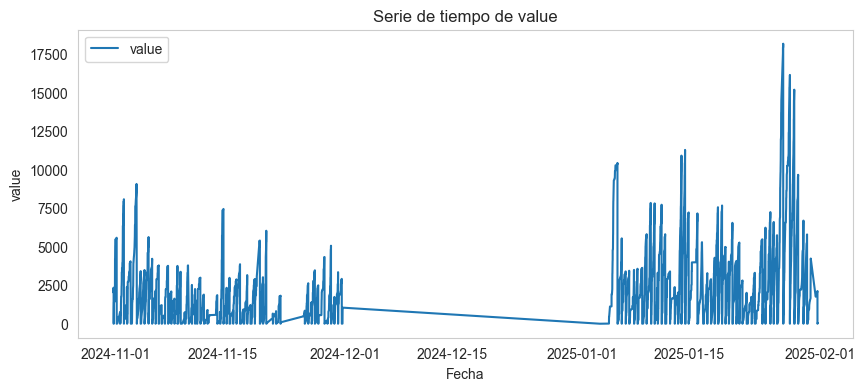

⚠ La columna 'message' no tiene datos numéricos válidos.


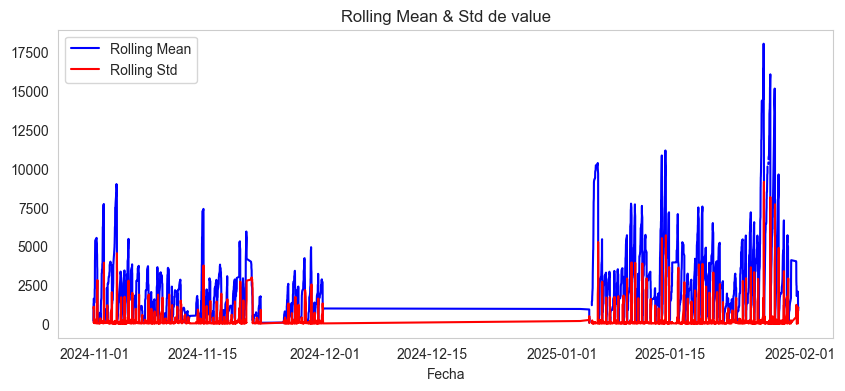

⚠ Ajustando rolling window a 1 para 'message' (pocos datos).


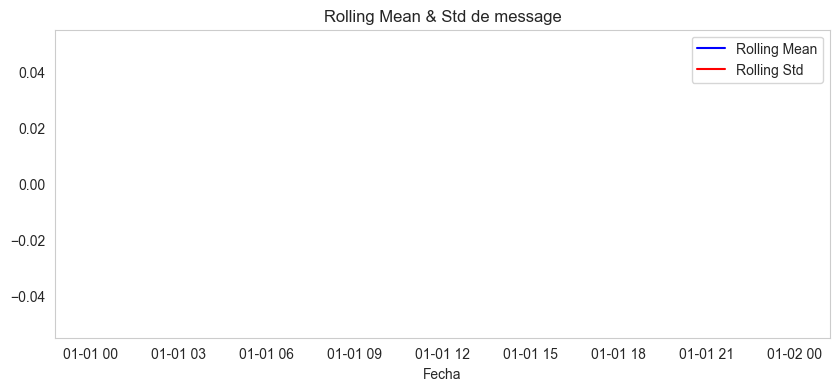

In [16]:

# ---- 1.3. Análisis Temporal y Tendencias ----
if "user_ts" in data.columns:
    print("\n✅ La columna 'fecha' existe. Convirtiendo a formato datetime...\n")
    
    data["user_ts"] = pd.to_datetime(data["user_ts"], errors="coerce")  # Manejo de errores
    data = data.dropna(subset=["user_ts"])  # Eliminar NaN en fechas
    data = data.sort_values(by="user_ts")

    print(data.info())  # Depuración: revisar si la conversión fue exitosa
    
    # Graficar series temporales
    for col in data.select_dtypes(include=np.number).columns:
        if data[col].dropna().empty:  # Evitar graficar columnas sin datos válidos
            print(f"⚠ La columna '{col}' no tiene datos numéricos válidos.")
            continue
        
        plt.figure(figsize=(10, 4))
        plt.plot(data["user_ts"], data[col], label=col)
        plt.title(f"Serie de tiempo de {col}")
        plt.xlabel("Fecha")
        plt.ylabel(col)
        plt.legend()
        plt.grid()
        plt.show(block=True)  # Asegura que se muestre el gráfico

    # Rolling Mean & Std
    for col in data.select_dtypes(include=np.number).columns:
        if len(data[col].dropna()) < 30:  # Ajustar el window si hay pocos datos
            window_size = max(1, len(data[col].dropna()) // 2)  # Ajusta a la mitad si hay pocos datos
            print(f"⚠ Ajustando rolling window a {window_size} para '{col}' (pocos datos).")
        else:
            window_size = 30

        plt.figure(figsize=(10, 4))
        plt.plot(data["user_ts"], data[col].rolling(window=window_size).mean(), label="Rolling Mean", color="blue")
        plt.plot(data["user_ts"], data[col].rolling(window=window_size).std(), label="Rolling Std", color="red")
        plt.title(f"Rolling Mean & Std de {col}")
        plt.xlabel("Fecha")
        plt.legend()
        plt.grid()
        plt.show(block=True)
else:
    print("\n❌ La columna 'fecha' no existe en el DataFrame.\n")

In [17]:
# Calcular Q1, Q3 e IQR
Q1 = data['value'].quantile(0.25)
Q3 = data['value'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Verificar los límites
print(f"Límite inferior: {lower_bound}")
print(f"Límite superior: {upper_bound}")

# Contar valores cercanos a los límites
print(f"Valores menores a {lower_bound + 0.1 * IQR}: {sum(data['value'] < (lower_bound + 0.1 * IQR))}")
print(f"Valores mayores a {upper_bound - 0.1 * IQR}: {sum(data['value'] > (upper_bound - 0.1 * IQR))}")

# Ajustar el criterio si es necesario
lower_bound_adj = Q1 - 2.0 * IQR
upper_bound_adj = Q3 + 2.0 * IQR

anomalies = data[(data['value'] < lower_bound_adj) | (data['value'] > upper_bound_adj)]

print("Anomalías detectadas (criterio ajustado):")
print(anomalies)

Límite inferior: -4168.5
Límite superior: 9747.5
Valores menores a -3820.6: 0
Valores mayores a 9399.6: 2812
Anomalías detectadas (criterio ajustado):
                               user_ts  \
48206 2025-01-26 22:08:51.930000+00:00   
48207 2025-01-26 22:08:52.931000+00:00   
48208 2025-01-26 22:09:18.948000+00:00   
48209 2025-01-26 22:09:19.948000+00:00   
48210 2025-01-26 22:10:03.978000+00:00   
...                                ...   
52128 2025-01-28 16:12:02.073000+00:00   
52129 2025-01-28 16:12:03.074000+00:00   
52130 2025-01-28 16:13:00.116000+00:00   
52131 2025-01-28 16:13:05.120000+00:00   
52132 2025-01-28 16:13:16.128000+00:00   

                                        variable    value  message  
48206  CONTIFORM_MMA.CONTIFORM_MMA1.WS_Tot_Rej.0  11493.0      NaN  
48207  CONTIFORM_MMA.CONTIFORM_MMA1.WS_Tot_Rej.0  11495.0      NaN  
48208  CONTIFORM_MMA.CONTIFORM_MMA1.WS_Tot_Rej.0  11498.0      NaN  
48209  CONTIFORM_MMA.CONTIFORM_MMA1.WS_Tot_Rej.0  11501.0      NaN  

In [ ]:

plt.figure(figsize=(12, 5))
plt.plot(data["user_ts"], data["value"], marker="o", linestyle="-")
plt.title("Evolución de 'value' en el tiempo")
plt.xticks(rotation=45)
plt.show()

In [ ]:

# 📌 Especificar la fecha y hora exacta para analizar
fecha_hora_inicio = "2024-11-15 12:20:00"
fecha_hora_fin = "2024-12-01 12:45:00"

# 📌 Filtrar datos dentro de ese intervalo
df_filtrado = data[(data["user_ts"] >= fecha_hora_inicio) & (data["user_ts"] <= fecha_hora_fin)]

# 📌 Verificar datos filtrados
print("Datos filtrados en el intervalo seleccionado:")
print(df_filtrado.head())

# 📊 📌 Analizar estadísticas básicas del comportamiento en esa hora
print("\nResumen estadístico:")
print(df_filtrado.describe())

# 📈 📌 Graficar evolución de las variables en el tiempo dentro de esa hora
plt.figure(figsize=(10, 4))
for col in df_filtrado.select_dtypes(include="number").columns:
    plt.plot(df_filtrado["user_ts"], df_filtrado[col], label=col)

plt.title(f"Comportamiento en el intervalo {fecha_hora_inicio} - {fecha_hora_fin}")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Datos filtrados en el intervalo seleccionado:
                               user_ts  \
13947 2024-11-01 12:20:10.675000+00:00   
13948 2024-11-01 12:20:12.677000+00:00   
13949 2024-11-01 12:20:14.678000+00:00   
13950 2024-11-01 12:20:15.679000+00:00   
13951 2024-11-01 12:20:16.679000+00:00   

                                                variable  value  message  
13947  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  114.0      NaN  
13948  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  113.0      NaN  
13949  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  114.0      NaN  
13950  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  113.0      NaN  
13951  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  114.0      NaN  

Resumen estadístico:
               value  message
count  866445.000000      0.0
mean      105.511856      NaN
std        29.750088      NaN
min        14.000000      NaN
25%       114.000000      NaN
50%       116.000000      NaN
75%       118.00000

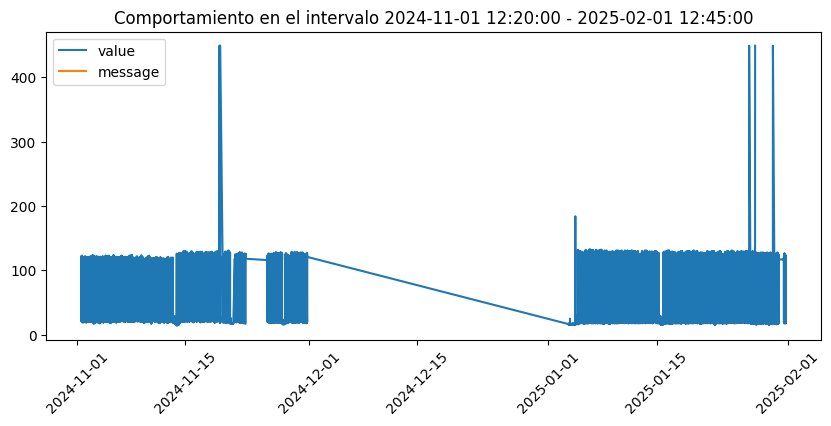

In [2]:

# 📌 Cargar el archivo CSV
archivo = "/Users/ximenacanton/Documents/TEC/4 SEM/ACD/pisa/CONTIFORM_MMA_CONTIFORM_MMA1_PreformTemperatureLayer_7.csv"  # Cambia esto por la ruta real de tu archivo
df = pd.read_csv(archivo)

# 📌 Convertir la columna de tiempo a formato datetime
df["user_ts"] = pd.to_datetime(df["user_ts"], format="ISO8601", errors="coerce")

# 📌 Especificar la fecha y hora exacta para analizar
fecha_hora_inicio = "2024-11-01 12:20:00"
fecha_hora_fin = "2025-02-01 12:45:00"

# 📌 Filtrar datos dentro de ese intervalo
df_filtrado = df[(df["user_ts"] >= fecha_hora_inicio) & (df["user_ts"] <= fecha_hora_fin)]

# 📌 Verificar datos filtrados
print("Datos filtrados en el intervalo seleccionado:")
print(df_filtrado.head())

# 📊 📌 Analizar estadísticas básicas del comportamiento en esa hora
print("\nResumen estadístico:")
print(df_filtrado.describe())

# 📈 📌 Graficar evolución de las variables en el tiempo dentro de esa hora
plt.figure(figsize=(10, 4))
for col in df_filtrado.select_dtypes(include="number").columns:
    plt.plot(df_filtrado["user_ts"], df_filtrado[col], label=col)

plt.title(f"Comportamiento en el intervalo {fecha_hora_inicio} - {fecha_hora_fin}")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [3]:

columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Calcular estadísticas para cada columna numérica
estadisticas = df[columnas_numericas].describe(percentiles=[0.25, 0.5, 0.75]).T
estadisticas["std"] = df[columnas_numericas].std()  # Agregar desviación estándar

# Mostrar resultados
print("Resumen estadístico de las variables numéricas:")
print(estadisticas)

Resumen estadístico de las variables numéricas:
            count        mean        std   min    25%    50%    75%    max
value    880392.0  105.551602  29.632421  14.0  114.0  116.0  118.0  449.0
message       0.0         NaN        NaN   NaN    NaN    NaN    NaN    NaN


In [4]:

# Total de registros
total_registros = df.shape[0]

# Valores nulos por columna
valores_nulos = df.isnull().sum()

# Valores duplicados
valores_duplicados = df.duplicated().sum()

# Mostrar resultados
print(f"🔹 Total de registros: {total_registros}")
print(f"🔹 Valores nulos por columna:\n{valores_nulos}")
print(f"🔹 Total de valores duplicados: {valores_duplicados}")

🔹 Total de registros: 880395
🔹 Valores nulos por columna:
user_ts          0
variable         0
value            3
message     880395
dtype: int64
🔹 Total de valores duplicados: 4512


<Figure size 1000x500 with 0 Axes>

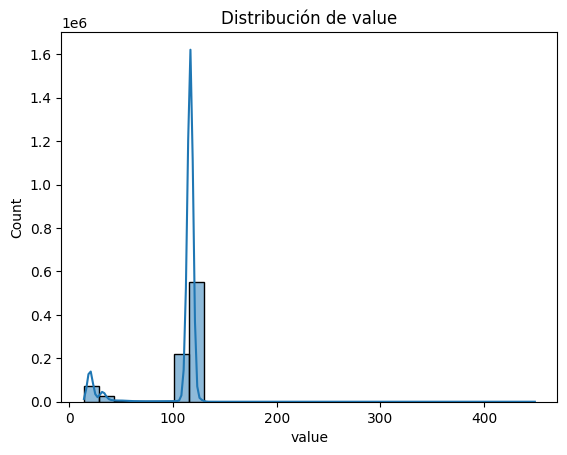

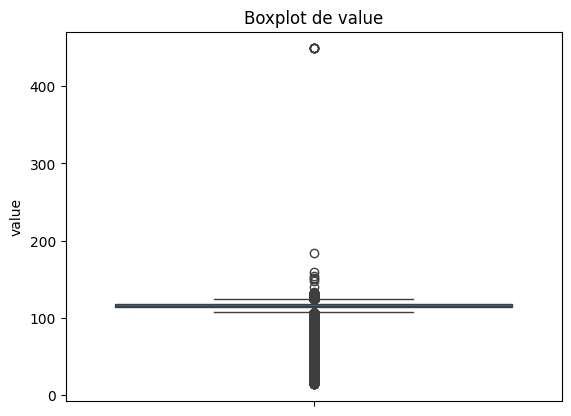

La columna 'message' tiene valores insuficientes para graficar.


In [5]:
# ---- 1.2. Análisis de Distribución y Detección de Outliers ----
plt.figure(figsize=(10, 5))

for col in df.select_dtypes(include=np.number).columns:
    col_df = df[col].dropna()  # Eliminar valores NaN
    
    if col_df.nunique() > 1:  # Verificar que haya más de un valor único
        # Histograma y KDE
        plt.figure()
        sns.histplot(col_df, kde=True, bins=30)
        plt.title(f"Distribución de {col}")
        plt.show()

        # Boxplot
        plt.figure()
        sns.boxplot(y=col_df)
        plt.title(f"Boxplot de {col}")
        plt.show()
    else:
        print(f"La columna '{col}' tiene valores insuficientes para graficar.")

In [6]:
Q1 = df_filtrado['value'].quantile(0.25)
Q3 = df_filtrado['value'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites de los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
anomalies = df_filtrado[(df_filtrado['value'] < lower_bound) | (df_filtrado['value'] > upper_bound)]

print("Anomalías detectadas:")
print(anomalies)

Anomalías detectadas:
                                user_ts  \
13991  2024-11-01 12:22:26.077000+00:00   
13992  2024-11-01 12:22:27.078000+00:00   
13993  2024-11-01 12:22:28.079000+00:00   
13994  2024-11-01 12:22:30.079000+00:00   
13995  2024-11-01 12:22:31.080000+00:00   
...                                 ...   
880390 2025-01-31 17:38:21.887000+00:00   
880391 2025-01-31 17:59:20.663000+00:00   
880392 2025-01-31 17:59:46.681000+00:00   
880393 2025-01-31 17:59:49.683000+00:00   
880394 2025-01-31 17:59:52.685000+00:00   

                                                 variable  value  message  
13991   CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...   43.0      NaN  
13992   CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...   34.0      NaN  
13993   CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...   33.0      NaN  
13994   CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...   30.0      NaN  
13995   CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...   25.0      NaN  
...  

In [9]:

# IQR (Método de rango intercuartílico) para detectar outliers
for col in df.select_dtypes(include=np.number).columns:
    col_df = df[col].dropna()  # Eliminar valores NaN

    Q1 = col_df.quantile(0.25)
    Q3 = col_df.quantile(0.75)
    IQR = Q3 - Q1

    outliers_iqr = col_df[(col_df < (Q1 - 1.5 * IQR)) | (col_df > (Q3 + 1.5 * IQR))]

    print(f"\nValores atípicos detectados en '{col}' por IQR:")
    if not outliers_iqr.empty:
        print(outliers_iqr)
    else:
        print("No se encontraron valores atípicos con IQR.")


Valores atípicos detectados en 'value' por IQR:
87        38.0
88        33.0
89        32.0
90        33.0
91        23.0
          ... 
880390    18.0
880391    19.0
880392    20.0
880393    19.0
880394    20.0
Name: value, Length: 113847, dtype: float64

Valores atípicos detectados en 'message' por IQR:
No se encontraron valores atípicos con IQR.


Datos filtrados en el intervalo seleccionado:
                                user_ts  \
263345 2024-11-15 12:20:07.664000+00:00   
263346 2024-11-15 12:20:08.665000+00:00   
263347 2024-11-15 12:20:09.666000+00:00   
263348 2024-11-15 12:20:10.667000+00:00   
263349 2024-11-15 12:20:11.667000+00:00   

                                                 variable  value  message  
263345  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...   25.0      NaN  
263346  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  123.0      NaN  
263347  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  122.0      NaN  
263348  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  123.0      NaN  
263349  CONTIFORM_MMA.CONTIFORM_MMA1.PreformTemperatur...  122.0      NaN  

Resumen estadístico:
               value  message
count  208835.000000      0.0
mean      109.647430      NaN
std        25.428101      NaN
min        16.000000      NaN
25%       116.000000      NaN
50%       117.000000      NaN
75%    

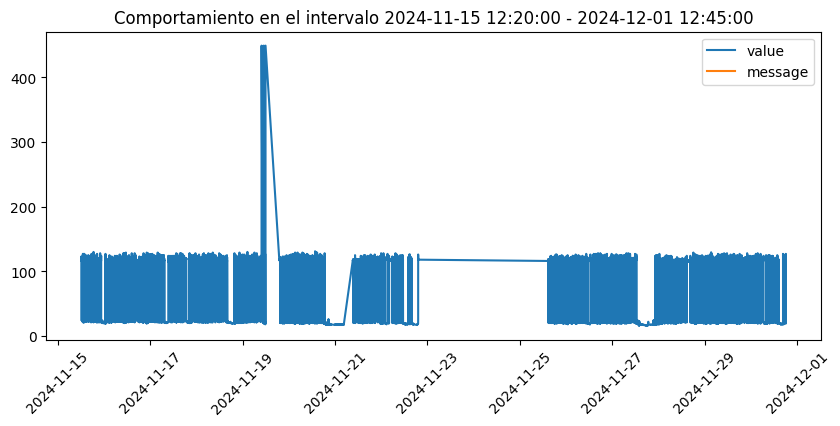

In [10]:

# 📌 Especificar la fecha y hora exacta para analizar
fecha_hora_inicio = "2024-11-15 12:20:00"
fecha_hora_fin = "2024-12-01 12:45:00"

# 📌 Filtrar datos dentro de ese intervalo
df_filtrado = df[(df["user_ts"] >= fecha_hora_inicio) & (df["user_ts"] <= fecha_hora_fin)]

# 📌 Verificar datos filtrados
print("Datos filtrados en el intervalo seleccionado:")
print(df_filtrado.head())

# 📊 📌 Analizar estadísticas básicas del comportamiento en esa hora
print("\nResumen estadístico:")
print(df_filtrado.describe())

# 📈 📌 Graficar evolución de las variables en el tiempo dentro de esa hora
plt.figure(figsize=(10, 4))
for col in df_filtrado.select_dtypes(include="number").columns:
    plt.plot(df_filtrado["user_ts"], df_filtrado[col], label=col)

plt.title(f"Comportamiento en el intervalo {fecha_hora_inicio} - {fecha_hora_fin}")
plt.legend()
plt.xticks(rotation=45)
plt.show()

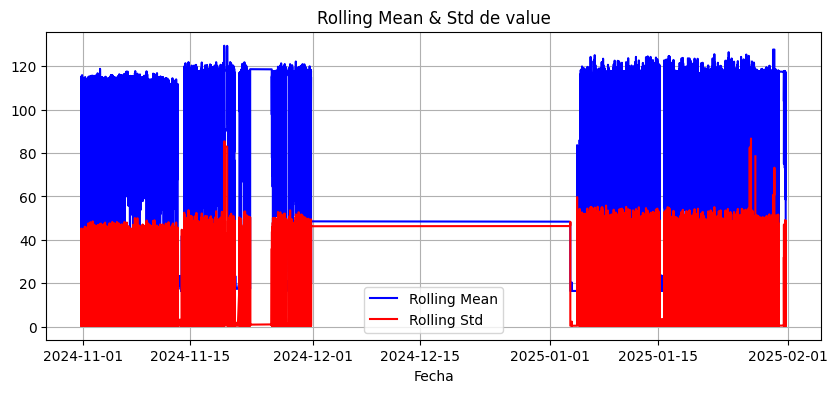

⚠ Ajustando rolling window a 1 para 'message' (pocos datos).


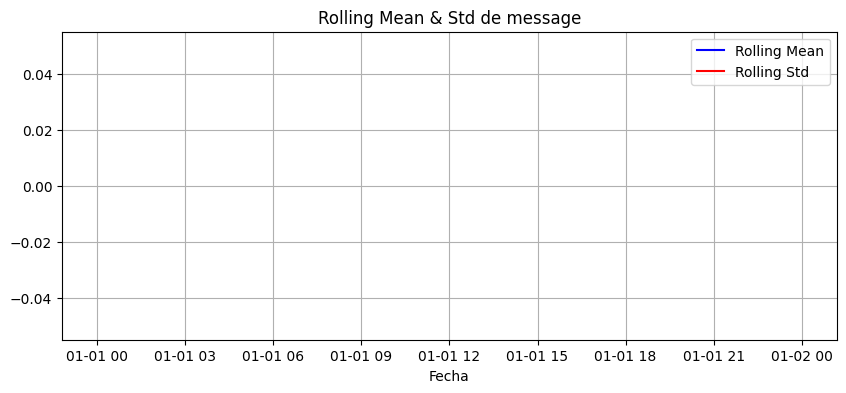

In [11]:

    # Rolling Mean & Std
for col in df.select_dtypes(include=np.number).columns:
        if len(df[col].dropna()) < 30:  # Ajustar el window si hay pocos datos
            window_size = max(1, len(df[col].dropna()) // 2)  # Ajusta a la mitad si hay pocos datos
            print(f"⚠ Ajustando rolling window a {window_size} para '{col}' (pocos datos).")
        else:
            window_size = 30

        plt.figure(figsize=(10, 4))
        plt.plot(df["user_ts"], df[col].rolling(window=window_size).mean(), label="Rolling Mean", color="blue")
        plt.plot(df["user_ts"], df[col].rolling(window=window_size).std(), label="Rolling Std", color="red")
        plt.title(f"Rolling Mean & Std de {col}")
        plt.xlabel("Fecha")
        plt.legend()
        plt.grid()
        plt.show(block=True)